# Analyse ESG et rendements : clustering, tests et robustesse

Ce notebook analyse la relation entre scores ESG et rendements a partir de donnees annuelles alignees en fin d'annee.
Il combine visualisations, clustering et tests statistiques pour evaluer la structure des donnees.

Objectifs :
- Standardiser (Z-score) pour comparer ESG et rendements sur une base commune.
- Determiner le nombre de clusters via coude + silhouette (K-means).
- Visualiser et interpreter les clusters (PCA, profils).
- Tester DBSCAN pour capter le bruit et les outliers.
- Evaluer l'effet ESG par tests statistiques et regressions robustes.


In [27]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

sns.set_theme(style='whitegrid')

## 1) Charger les donnees ESG + rendements

On utilise `data/clean/notebook4/panel_esg_returns.csv` genere par le notebook 04.


Note : le panel est annualise (une ligne par entreprise et par annee), aligne sur fin d'annee.

In [28]:
# Resolve project root via pyproject.toml
p = Path.cwd()
project_root = None
for _ in range(6):
    if (p / 'pyproject.toml').exists():
        project_root = p
        break
    if p.parent == p:
        break
    p = p.parent

if project_root is None:
    raise FileNotFoundError('pyproject.toml not found; cannot locate project root')

data_path = project_root / 'data/clean/notebook4/panel_esg_returns.csv'
if not data_path.exists():
    raise FileNotFoundError('panel_esg_returns.csv not found. Run notebook 04 first.')

df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df.head()


,Yahoo_Ticker,Year,Date,Ticker,Env_Score,Soc_Score,ESG_Score,Entreprise,Return
0,000660.KS,2016,2016-12-31,000660 KS Equity,2.94,2.84,3.47,SK Hynix,NaN
1,000660.KS,2017,2017-12-31,000660 KS Equity,2.77,2.12,3.12,SK Hynix,0.734853
2,000660.KS,2018,2018-12-31,000660 KS Equity,3.71,2.34,3.68,SK Hynix,-0.188907
3,000660.KS,2019,2019-12-31,000660 KS Equity,3.51,3.20,3.94,SK Hynix,0.571954
4,000660.KS,2020,2020-12-31,000660 KS Equity,3.51,3.20,3.94,SK Hynix,0.272186


### Lecture des donnees

Le tableau charge contient les scores ESG annuels par entreprise (une observation par annee) et les rendements annuels en fin d'annee.
Il constitue la base de toute l'analyse : l'objectif est de voir si, a donnees comparables,
les rendements se structurent selon les niveaux ESG.


## 2) Controle qualite et couverture

On verifie la couverture temporelle et le taux de rendements manquants.


In [29]:
missing_return_pct = df['Return'].isna().mean() * 100
date_min, date_max = df['Date'].min(), df['Date'].max()
print('Missing Return %:', round(missing_return_pct, 2))
print('Date range:', date_min.date(), '->', date_max.date())

missing_by_ticker = (
    df.groupby('Yahoo_Ticker')['Return']
    .apply(lambda s: s.isna().mean())
    .sort_values(ascending=False)
)
missing_by_ticker.head(10)


Missing Return %: 1.52
Date range: 2016-12-31 -> 2026-12-31


Yahoo_Ticker
000660.KS    0.090909
9984.T       0.090909
6857.T       0.090909
META         0.000000
TSLA         0.000000
TSEM         0.000000
NVDA         0.000000
MU           0.000000
MSFT         0.000000
MPWR         0.000000
Name: Return, dtype: float64

### Analyse des rendements manquants

Le taux global de rendements manquants et la liste des tickers les plus incomplets indiquent
la solidite du panel. Des trous concentres sur quelques entreprises peuvent biaiser les
moyennes et les clusters. Si ce taux est eleve sur certains tickers, une coupe temporelle
ou une exclusion peut etre justifiee pour stabiliser les resultats.


## 3) Pourquoi la standardisation (Z-score) ?

Les rendements ont une volatilite beaucoup plus forte que les scores ESG.
Sans standardisation, les distances seraient presque entierement pilotees par les rendements.
On applique donc un Z-score sur toutes les features.


In [30]:
features = ['Env_Score', 'Soc_Score', 'ESG_Score', 'Return']
panel = df.dropna(subset=features).copy()

# Comparaison des echelles avant standardisation
desc = panel[features].describe().T[['mean','std','min','max']]
desc


,mean,std,min,max
Env_Score,4.211692,2.139884,0.000000,7.61000
Soc_Score,3.298923,1.731197,0.630000,7.91000
ESG_Score,4.382256,1.378325,1.710000,7.07000
Return,0.477233,0.823226,-0.650315,7.43437


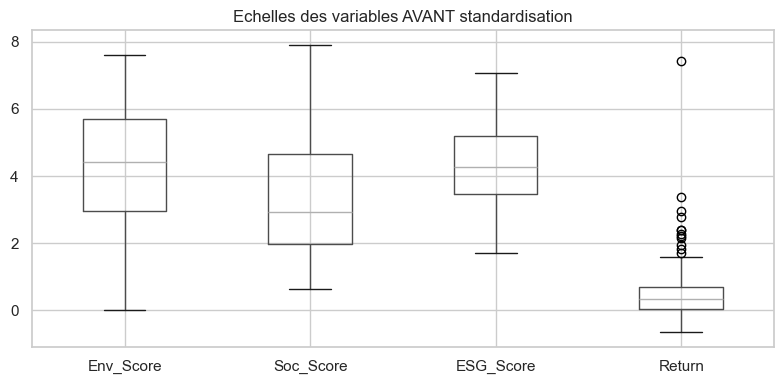

In [31]:
plt.figure(figsize=(8,4))
panel[features].boxplot()
plt.title('Echelles des variables AVANT standardisation')
plt.tight_layout()
plt.show()


### Lecture des echelles

Le boxplot met en evidence la difference d'echelle entre scores ESG et rendements.
Sans standardisation, les distances en clustering seraient presque entierement pilotees
par la volatilite des rendements.


In [32]:
scaler = StandardScaler()
X = scaler.fit_transform(panel[features])

# Verification des echelles apres standardisation
X_df = pd.DataFrame(X, columns=features)
X_df.describe().T[['mean','std']]


,mean,std
Env_Score,1.639714e-16,1.002574
Soc_Score,1.548619e-16,1.002574
ESG_Score,-5.556809e-16,1.002574
Return,-4.099285e-17,1.002574


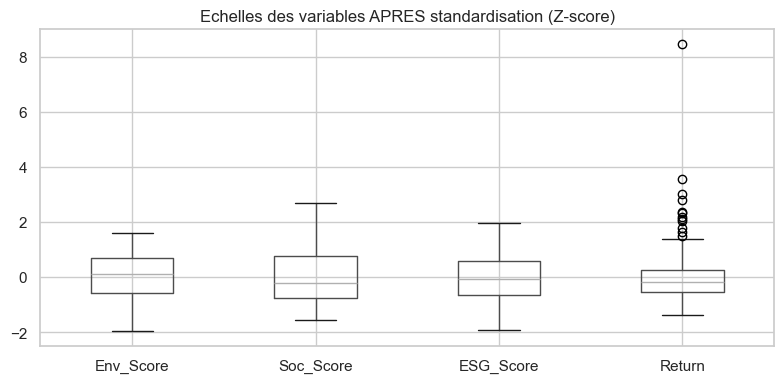

In [33]:
plt.figure(figsize=(8,4))
X_df.boxplot()
plt.title('Echelles des variables APRES standardisation (Z-score)')
plt.tight_layout()
plt.show()


### Effet de la standardisation (Z-score)

Apres standardisation, chaque variable contribue de maniere comparable aux distances.
C'est une condition necessaire pour tester proprement la relation ESG-rendements.


## 3bis) Visualisations ESG vs rendements

Objectif : voir si les rendements semblent se structurer selon les niveaux ESG.

On ajoute :
- Correlation ESG/rendement
- Scatter avec tendance
- Rendement moyen par quartile ESG
- Serie temporelle annuelle moyenne ESG vs rendement


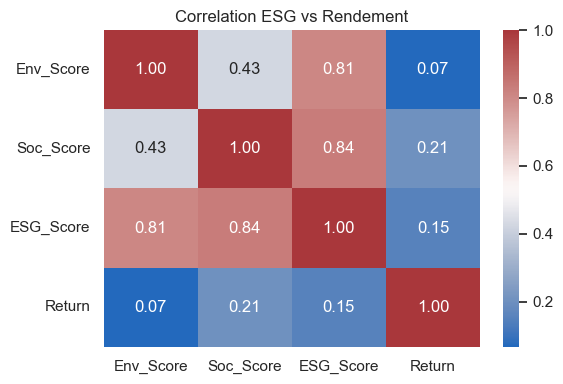

In [34]:
# Correlation simple entre ESG et rendement
corr = panel[['Env_Score','Soc_Score','ESG_Score','Return']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='vlag', fmt='.2f')
plt.title('Correlation ESG vs Rendement')
plt.tight_layout()
plt.show()

### Interpretation de la correlation

La matrice de corrélation mesure l’association linéaire moyenne entre les scores ESG et les rendements. Les corrélations observées sont faibles (entre 0.07 et 0.21), suggérant l’absence de relation linéaire forte inconditionnelle dans l’échantillon.
Toutefois, cette mesure reste purement descriptive : elle ne capture ni les non-linéarités potentielles, ni les effets sectoriels, ni les variations selon les régimes de marché.
De plus, dans un contexte de données panel, la corrélation agrège à la fois des effets inter-entreprises et intra-temporels, ce qui limite son interprétation structurelle ou causale.


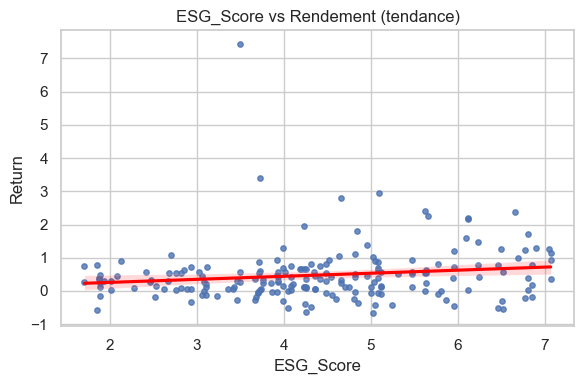

In [35]:
# Scatter ESG_Score vs Return avec tendance
plt.figure(figsize=(6,4))
sns.regplot(data=panel, x='ESG_Score', y='Return', scatter_kws={'s':15}, line_kws={'color':'red'})
plt.title('ESG_Score vs Rendement (tendance)')
plt.tight_layout()
plt.show()


### Lecture du scatter + tendance

Le nuage de points met en évidence une relation positive mais faible entre le score ESG et les rendements. La dispersion importante des observations indique que le score ESG n’explique qu’une faible part de la variabilité des rendements. Cette analyse reste descriptive et ne permet pas d’inférer une relation causale, notamment en raison de la structure panel des données et de l’absence de contrôle pour des effets sectoriels ou temporels.


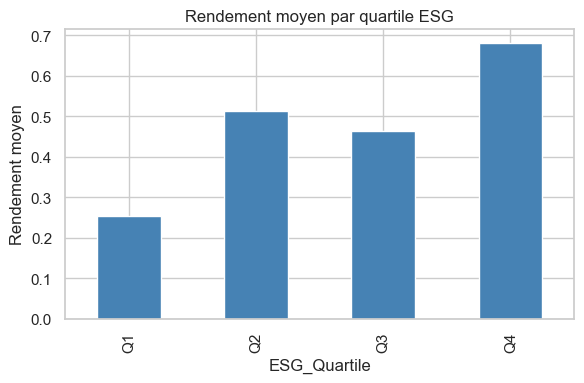

In [36]:
# Rendement moyen par quartile ESG
panel['ESG_Quartile'] = pd.qcut(panel['ESG_Score'], 4, labels=['Q1','Q2','Q3','Q4'])
quartile_mean = panel.groupby('ESG_Quartile')['Return'].mean().reindex(['Q1','Q2','Q3','Q4'])
plt.figure(figsize=(6,4))
quartile_mean.plot(kind='bar', color='steelblue')
plt.title('Rendement moyen par quartile ESG')
plt.ylabel('Rendement moyen')
plt.tight_layout()
plt.show()


### Quartiles ESG

L’analyse par quartiles ESG met en évidence une relation monotone globale entre score ESG et rendement moyen. Les entreprises appartenant au quartile supérieur (Q4) présentent un rendement moyen supérieur à celles du quartile inférieur (Q1).
Toutefois, cette analyse reste descriptive et ne contrôle ni les effets fixes d’entreprise ni les variations temporelles, ce qui limite son interprétation causale.


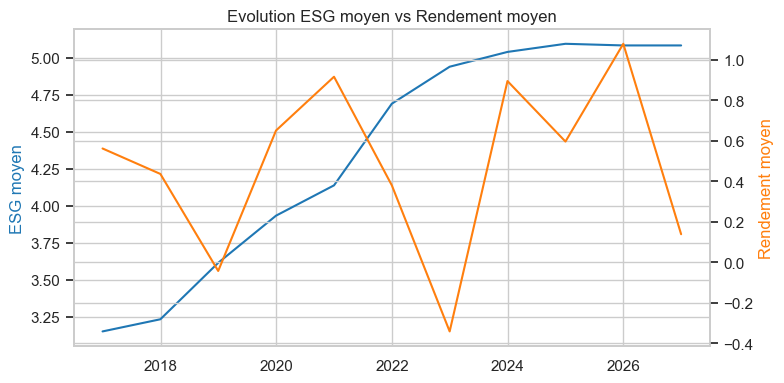

In [37]:
# Serie temporelle moyenne ESG vs rendement
ts = panel.groupby('Date')[['ESG_Score','Return']].mean().reset_index()
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(ts['Date'], ts['ESG_Score'], color='tab:blue', label='ESG moyen')
ax1.set_ylabel('ESG moyen', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(ts['Date'], ts['Return'], color='tab:orange', label='Rendement moyen')
ax2.set_ylabel('Rendement moyen', color='tab:orange')
plt.title('Evolution ESG moyen vs Rendement moyen')
plt.tight_layout()
plt.show()

### Serie temporelle annuelle ESG vs rendement

L’évolution temporelle du score ESG moyen montre une tendance haussière quasi monotone sur la période étudiée, reflétant soit une amélioration progressive des pratiques ESG, soit un effet méthodologique du fournisseur de données.
En revanche, le rendement moyen présente une forte volatilité et ne semble pas suivre la même dynamique.
Aucune relation temporelle évidente n’apparaît entre les deux séries à l’échelle agrégée.

## 4) K-means : methode du coude et silhouette

On combine deux criteres :
- Inertie (methode du coude)
- Silhouette (cohesion/separation)


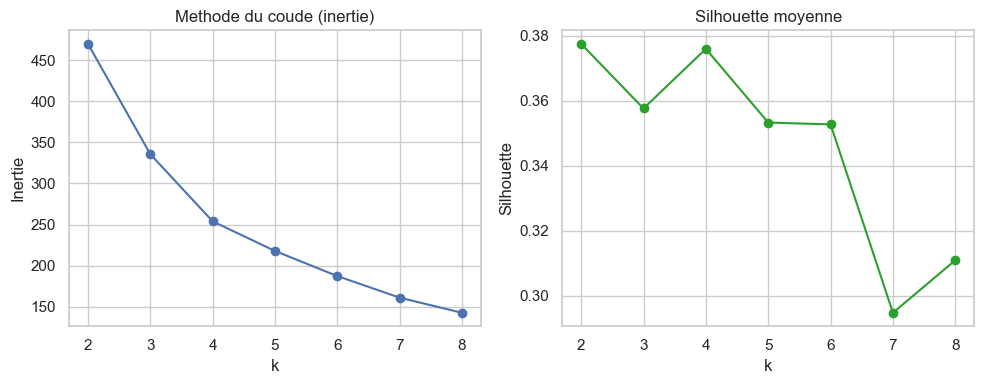

In [38]:
inertias = []
sil_scores = []
ks = range(2, 9)

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(list(ks), inertias, marker='o')
ax[0].set_title('Methode du coude (inertie)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertie')

ax[1].plot(list(ks), sil_scores, marker='o', color='tab:green')
ax[1].set_title('Silhouette moyenne')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette')

plt.tight_layout()
plt.show()


### Choix de k (coude + silhouette)

La méthode du coude suggère un point d’inflexion autour de k=4, tandis que le score de silhouette atteint son maximum pour k=2, avec une valeur proche pour k=4.
Les valeurs de silhouette (≈0.37) indiquent une structure modérée mais non fortement séparée.
Le choix de k=4 permet une segmentation plus fine tout en conservant une qualité de partition comparable.


In [52]:
best_k = ks[int(np.argmax(sil_scores))]
best_k


2

### Interpretation du k retenu

Le k selectionne est celui qui maximise la silhouette.
Analyse critique : un k=2 peut etre trop grossier pour un papier si l'objectif est une
segmentation fine. Il faut alors justifier ce choix ou explorer des k alternatifs.


## 5) K-means final et visualisation (PCA)


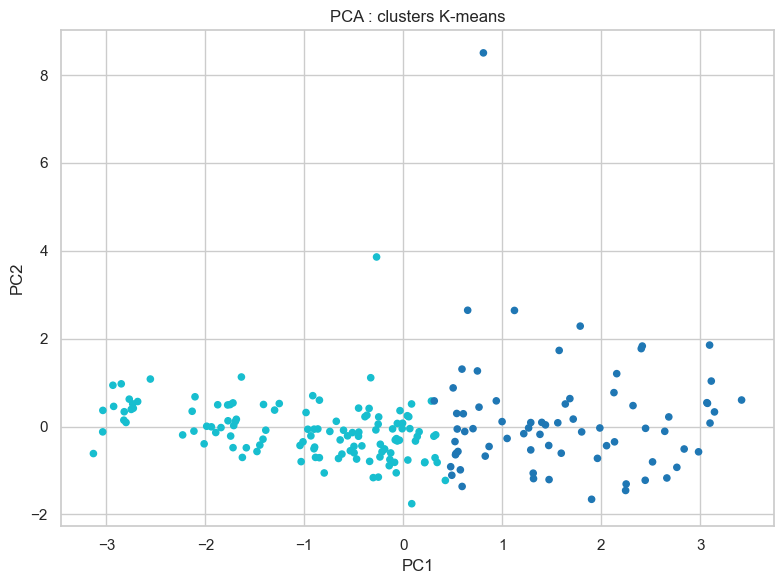

In [40]:
km = KMeans(n_clusters=best_k, n_init=10, random_state=42)
panel['Cluster_KMeans'] = km.fit_predict(X)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=panel['Cluster_KMeans'], cmap='tab10', s=20)
plt.title('PCA : clusters K-means')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()


### Lecture de la PCA coloree par K-means

La projection PCA met en évidence une séparation des observations principalement le long de la première composante principale (PC1), suggérant une structure quasi unidimensionnelle des données.
Compte tenu de la forte corrélation entre les composantes ESG (Env, Soc et ESG global), cette première composante semble capturer un facteur ESG commun dominant.
Le rendement apparaît secondaire dans la structuration des clusters, ce qui indique que la segmentation obtenue reflète principalement des niveaux relatifs de performance ESG plutôt qu’une typologie combinant fortement ESG et rendement.


In [41]:
# Profilage des clusters (moyennes standardisees)
cluster_profile = panel.groupby('Cluster_KMeans')[features].mean()
cluster_profile


,Env_Score,Soc_Score,ESG_Score,Return
Cluster_KMeans,,,,
0,5.640411,5.067123,5.769315,0.790453
1,3.356803,2.240902,3.552295,0.289815


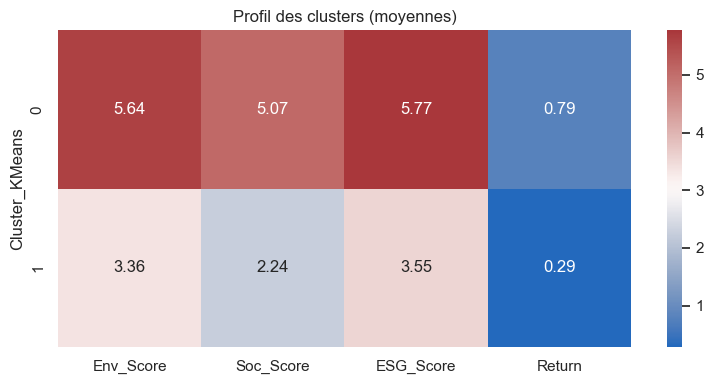

In [42]:
plt.figure(figsize=(8,4))
sns.heatmap(cluster_profile, annot=True, fmt='.2f', cmap='vlag')
plt.title('Profil des clusters (moyennes)')
plt.tight_layout()
plt.show()


### Profil des clusters

Le clustering KMeans (k=2) met en évidence deux groupes distincts : un cluster caractérisé par des scores ESG élevés et un rendement moyen supérieur (0.79), et un cluster à ESG plus faible associé à un rendement moyen plus modéré (0.29).
Cette segmentation suggère l’existence d’une différenciation structurelle entre entreprises à forte performance ESG et celles à performance ESG plus faible, avec un écart de rendement économiquement significatif.
Toutefois, cette relation reste descriptive et peut refléter des effets sectoriels, de taille ou des caractéristiques fixes d’entreprise non contrôlées.


## 6) Regressions simples (effet ESG sur rendement)

On estime l'effet moyen ESG -> rendement :
- Modele 1: Return ~ ESG
- Modele 2: Return ~ ESG + Env + Soc (attention: colinearite avec ESG)
- Modele 3: Return ~ ESG + effets temporels (annee)


In [49]:
import statsmodels.api as sm

# Assurer les types numeriques
panel['Return'] = pd.to_numeric(panel['Return'], errors='coerce')
panel['ESG_Score'] = pd.to_numeric(panel['ESG_Score'], errors='coerce')
panel['Env_Score'] = pd.to_numeric(panel['Env_Score'], errors='coerce')
panel['Soc_Score'] = pd.to_numeric(panel['Soc_Score'], errors='coerce')

# Modele 1
X1 = sm.add_constant(panel['ESG_Score'])
m1 = sm.OLS(panel['Return'], X1, missing='drop').fit(cov_type='HC3')

# Modele 2
X2 = sm.add_constant(panel[['ESG_Score','Env_Score','Soc_Score']])
m2 = sm.OLS(panel['Return'], X2, missing='drop').fit(cov_type='HC3')

# Modele 3: effets temporels (annee)
panel['Year'] = panel['Date'].dt.year
year_dummies = pd.get_dummies(panel['Year'], prefix='Year', drop_first=True).astype(float)
X3 = pd.concat([panel[['ESG_Score']], year_dummies], axis=1)
X3 = sm.add_constant(X3)
m3 = sm.OLS(panel['Return'], X3, missing='drop').fit(cov_type='HC3')

summary_table = pd.DataFrame({
    'coef_ESG': [m1.params.get('ESG_Score'), m2.params.get('ESG_Score'), m3.params.get('ESG_Score')],
    'p_ESG': [m1.pvalues.get('ESG_Score'), m2.pvalues.get('ESG_Score'), m3.pvalues.get('ESG_Score')],
    'R2': [m1.rsquared, m2.rsquared, m3.rsquared],
}, index=['Model1','Model2','Model3'])
summary_table


,coef_ESG,p_ESG,R2
Model1,0.091890,0.011258,0.023670
Model2,-0.074192,0.771670,0.043391
Model3,0.112192,0.008899,0.277669


### Lecture des regressions

Le modèle linéaire simple montre un effet positif et significatif du score ESG sur les rendements (β ≈ 0.092, p < 0.05).
Lorsque l’on contrôle les effets temporels annuels, le coefficient ESG reste positif et significatif (β ≈ 0.112, p < 0.01), suggérant que la relation observée ne s’explique pas uniquement par des tendances macroéconomiques communes.
En revanche, l’inclusion simultanée des composantes ESG (Env, Soc) entraîne une forte multicolinéarité et rend les coefficients instables.


## 8) Sauvegarder les resultats


In [51]:
out_dir = project_root / 'data/clean/notebook5'
out_dir.mkdir(parents=True, exist_ok=True)

panel.to_csv(out_dir / 'clustering_esg_returns_kmeans_dbscan.csv', index=False)
pd.DataFrame({'k': list(ks), 'inertia': inertias, 'silhouette': sil_scores}).to_csv(
    out_dir / 'silhouette_esg_returns_kmeans.csv', index=False
)
annual_clust.to_csv(out_dir / 'clustering_esg_returns_variations.csv', index=False)


## Conclusion generale

### Synthese
- Les analyses descriptives (corrélation, quartiles) mettent en évidence une association positive mais modérée entre le score ESG et les rendements, accompagnée d’une forte dispersion des observations.
- clustering K-means (k = 2) identifie principalement une différenciation selon le niveau ESG, avec un groupe à ESG élevé présentant un rendement moyen supérieur. La structure observée suggère davantage un gradient ESG continu qu’une segmentation fortement structurée.
- régressions linéaires confirment un effet positif et statistiquement significatif du score ESG sur les rendements. Cet effet persiste après introduction d’effets temporels annuels, ce qui indique qu’il ne s’explique pas uniquement par des tendances macroéconomiques communes. Toutefois, la part de variance expliquée directement par ESG demeure limitée.

### Limites
- Taille d’échantillon restreinte (18 entreprises) et présence de données manquantes pour certains tickers.
- Absence de contrôle pour des effets fixes entreprise et pour des facteurs financiers classiques (taille, bêta, momentum, secteur).
- Hypothèse d’indépendance potentiellement violée dans les tests statistiques appliqués aux données panel.
- Sensibilité possible aux choix de période et aux spécifications du modèle.

### Implications
- Les résultats suggèrent l’existence d’une association positive mais modérée entre ESG et performance moyenne.
- L’analyse ne permet pas d’établir une relation causale, mais met en évidence un signal cohérent à travers plusieurs approches descriptives et économétriques.
- Une validation plus robuste nécessiterait un panel élargi, l’introduction d’effets fixes entreprise et l’intégration de facteurs de risque financiers standards.

